# TODO

* Update the conserved BMI network to be public? Can we just share directly with the reviewers? Maybe public but not searchable?
* Update labels of the volcano plot - choose which to use.
* Finalize body size traits for GSR and enrichment analysis
* Final annotation - check against latest GO results?
**DONE**
* Fix the final annotations - use updated gene names before GO enrichment- didn't make a difference


# Introduction

In [16]:
rerun_analysis=False

# Set Up

In [17]:
# load required libraries
import os
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Set up directory paths. Defaults to the Data/ and Figures/ folders within the repository.
cwd = os.path.dirname(os.getcwd())
DATADIR = os.path.join(cwd, "Data/")
FIGDIR = os.path.join(cwd, "Figures/")

In [19]:
# Import functions specific to this study
sys.path.append(cwd)
from updated_netcoloc_functions import *
from analysis_functions import *

## Load input gene sets and interaction network

In [20]:
## Load the final seed gene lists
seed_bin_human_BMI = pd.read_csv(DATADIR+"inputs/human_BMI_all_seed_genes.txt", header=None)[0].tolist()
print("Number of human BMI seeds:", len(seed_bin_human_BMI))

seed_bin_rat_BMI=pd.read_csv(DATADIR+'inputs/ratBMI_seed_relaxed.txt',sep='\t')['0'].tolist()
print("Number of rat BMI seeds:", len(seed_bin_rat_BMI))

Number of human BMI seeds: 1958
Number of rat BMI seeds: 295


In [21]:
pc_nodes, G_PC = load_pcnet()

number of nodes:
18820

number of edges:
2693109


## Load the conserved BMI network

In [23]:
# import the conserved network
ndex_server='public.ndexbio.org'
ndex_user=getpass("Username:")
ndex_password=getpass("Password:")
G_BMI_coloc_cx = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid='e8cc9239-d91a-11eb-b666-0ac135e8bacf'
        )


# print out interactome num nodes and edges for diagnostic purposes
G_BMI_coloc = G_BMI_coloc_cx.to_networkx()
print('number of nodes:', len(G_BMI_coloc.nodes))
print('\nnumber of edges:', len(G_BMI_coloc.edges))

Username:········
Password:········
number of nodes: 657

number of edges: 5287


# Hierarchical Community Detection with HiDeF

In [24]:
# perform heirarchical community detection
if rerun_analysis:
    cd = cdapsutil.CommunityDetection()
    G_BMI_hier = cd.run_community_detection(G_BMI_coloc_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'10'})
    # Print information about hierarchy
    print('Hierarchy name: ' + str(G_BMI_hier.get_name()))
    print('# nodes: ' + str(len(G_BMI_hier.get_nodes())))
    print('# edges: ' + str(len(G_BMI_hier.get_edges())))
    G_BMI_hier = G_BMI_hier.to_networkx()
    BMI_hier_df = pd.DataFrame.from_dict(dict(G_BMI_hier.nodes(data=True)), orient="index")
    #hier_df_genes = hier_df.loc[:, ["CD_MemberList", "frac_d1_seeds", "frac_d2_seeds"]]
else:
    BMI_hier_df = pd.read_csv(DATADIR+ "outputs/BMI_hierarchy_data.tsv", sep="\t", index_col=0)

# Community Annotation

## Seed gene fractions

In [25]:
def get_seed_gene_fractions(hier_df, seeds1, seeds2, seed1_name='h_seed', seed2_name='r_seed'):
    hier_df["CD_MemberList"] = hier_df.CD_MemberList.apply(lambda x: x if type(x)==list else x.split(" "))
    comm_genes = hier_df.explode("CD_MemberList")
    comm_genes[seed1_name] = [1 if x in seeds1 else 0 for x in comm_genes.CD_MemberList]
    comm_genes[seed2_name] = [1 if x in seeds2 else 0 for x in comm_genes.CD_MemberList]
    comm_genes["overlap"] = comm_genes.apply(lambda x: x[seed1_name] * x[seed2_name], axis=1)
    a = comm_genes.groupby(level=0).overlap.sum()
    b = comm_genes[comm_genes.overlap != 1].groupby(level=0)[seed1_name].sum()
    c = comm_genes[comm_genes.overlap != 1].groupby(level=0)[seed2_name].sum()
    d = comm_genes.groupby(level=0).CD_MemberList.count()
    counts = pd.concat([a,b,c,d], axis=1)
    counts["network"] = counts.apply(lambda x: x.CD_MemberList - x.overlap - x[seed1_name] - x[seed2_name], axis=1)
    fracs = counts.div(counts.CD_MemberList, axis=0)
    return fracs

In [26]:
# Get fractions of seed genes
seed_fractions = get_seed_gene_fractions(BMI_hier_df, seed_bin_human_BMI, seed_bin_rat_BMI)
seed_fractions.to_csv(DATADIR+"outputs/BMI_hierarchy_community_seed_fractions.tsv", index=True, header=True, sep= "\t")
seed_fractions.head()

,overlap,h_seed,r_seed,CD_MemberList,network
C877,0.032710,0.320872,0.144860,1.0,0.501558
C878,0.037383,0.294393,0.130841,1.0,0.537383
C879,0.041420,0.295858,0.142012,1.0,0.520710
C880,0.012739,0.369427,0.159236,1.0,0.458599
C881,0.014706,0.441176,0.161765,1.0,0.382353


## Initial Annotation with GO

Annotate with moderately sized systems (between 50 to 1000 genes per system) if the community shows a significant ($p<1\times 10^{-4}$) enrichment for the term. Also require that the GO term and community and share at least 3 genes to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.

**Note:**  
Rerunning the annotation may generate slightly different results due to changes in the GO:BP database over time. The original results were generated January 18, 2022.

In [243]:
def filter_go_annotations(go_df, term_min=50, term_max=1000, p_th=1e-4, min_intersection=3):
    go_df = go_df[(go_df['term_size'] <= term_max) & (go_df['term_size'] >= term_min)]
    go_df = go_df[go_df['intersection_size'] >= min_intersection]
    go_df = go_df[go_df['p_value'] < p_th] # set a stringent pvalue threshold
    go_df['sum_PR'] = go_df['recall'] + go_df['precision']
    go_df = go_df.sort_values('sum_PR',ascending=False)
    return go_df

In [262]:
# Annotate with GO terms
# gprofiler annotation of clusters
if rerun_analysis:
    system_names = {}
    all_results = []
    for comm in BMI_hier_df.index.tolist():
        if isinstance(BMI_hier_df['CD_MemberList'].loc[comm], str):
            focal_genes=BMI_hier_df['CD_MemberList'].loc[comm].split(' ')
        else:
            focal_genes=BMI_hier_df['CD_MemberList'].loc[comm]
        print(comm,":", len(focal_genes))
        system_names[comm] = comm # default is to keep identifier as name, will be replaced if confident annotation available
        if len(focal_genes)>2:
            gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['GO:BP'], no_evidences=False))
            if len(gp_temp)>0: # make sure data is not empty
                gp_temp["community"] = comm
                all_results.append(gp_temp)
                gp_temp = filter_go_annotations(gp_temp, 50, 1000, 1e-3, 3)
                if len(gp_temp)>1:
                    system_names[comm] = gp_temp.head(1)['name'].tolist()[0]
                    #all_results.append(gp_temp)
    go_results = pd.concat(all_results)
    go_results.to_csv(DATADIR+"outputs/full_GO_enrichment_rerun.tsv", index=True, sep="\t")
            
else:
    go_results = pd.read_csv(DATADIR+ "outputs/full_GO_enrichment.tsv", index_col=None, sep="\t")
    go_results = filter_go_annotations(go_results, 50, 1000, 1e-3, 3)
    system_names = {}
    for comm in BMI_hier_df.index.tolist():
        if comm in go_results['community'].tolist():
            system_names[comm] = go_results[go_results['community']==comm]['name'].tolist()[0]
        else:
            system_names[comm] = comm

In [263]:
system_names

{'C877': 'proteoglycan biosynthetic process',
 'C898': 'C898',
 'C904': 'negative regulation of transcription by RNA polymerase II',
 'C906': 'C906',
 'C911': 'C911',
 'C913': 'C913',
 'C914': 'C914',
 'C915': 'C915',
 'C924': 'C924',
 'C925': 'C925',
 'C926': 'C926',
 'C930': 'C930',
 'C931': 'regulation of small GTPase mediated signal transduction',
 'C933': 'C933',
 'C935': 'C935',
 'C937': 'C937',
 'C878': 'glycosaminoglycan biosynthetic process',
 'C880': 'C880',
 'C882': 'demethylation',
 'C885': 'negative regulation of cell differentiation',
 'C887': 'detection of chemical stimulus involved in sensory perception of smell',
 'C888': 'intracellular protein transport',
 'C889': 'MAPK cascade',
 'C890': 'C890',
 'C892': 'C892',
 'C895': 'C895',
 'C883': 'glycosaminoglycan biosynthetic process',
 'C879': 'calcium-ion regulated exocytosis',
 'C932': 'C932',
 'C901': 'C901',
 'C902': 'C902',
 'C907': 'muscle system process',
 'C909': 'negative regulation of phosphatase activity',
 'C88

## Manual curation of GO terms

The final annotations of the conserved BMI systems map were determined via manual curation of the significant GO terms. 

In [380]:
final_annotations = pd.read_csv(DATADIR+"outputs/BMI_hierarchy_curated_annotations.tsv", sep="\t", index_col=None)
final_annotations = final_annotations.set_index("community")
final_annotations

,annotation
community,
C877,Conserved BMI Network (root)
C878,Nervous System Development
C879,Synaptic Signaling
C880,Chromosome Organization
C881,mRNA Metabolic Process
...,...
C933,C933
C934,Transcription Initiation RNA Poly II
C935,C935


In [381]:
annotated_systems = final_annotations[final_annotations.index != final_annotations.annotation]
annotated_systems

,annotation
community,
C877,Conserved BMI Network (root)
C878,Nervous System Development
C879,Synaptic Signaling
C880,Chromosome Organization
C881,mRNA Metabolic Process
C882,Demethylation 1
C883,Glycosaminoglycan Biosynthetic Process
C884,Exocytosis
C885,Regulation of Cell Differentiation


# Validation

## Load Mouse Genome Database (MGD) data

In [90]:
# load mappings between genes and mammalian phenotypes
mgi_df = load_MGI_mouseKO_data(url='http://www.informatics.jax.org/downloads/reports/MGI_PhenoGenoMP.rpt', 
                               map_using="mgi", update=False, data_loc=DATADIR+"Reference/")

In [91]:
updated_pc_nodes = mg.querymany(pc_nodes, as_dataframe=True, species='human', scopes='symbol, alias', fields='symbol')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-18820...done.
Finished.
1116 input query terms found dup hits:
	[('FBXO30', 2), ('KLHL21', 2), ('ARF1', 2), ('CIAO2B', 2), ('ILF2', 2), ('ASB13', 2), ('DZIP3', 2), 
162 input query terms found no hit:
	['AC022826.2', 'AL136295.5', 'MT-CO3', 'LOC105369243', 'AL136295.1', 'LOC101060399', 'AC006486.1', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [96]:
updated_pc_nodes = updated_pc_nodes.sort_values(by="_score", ascending=False)
updated_pc_nodes = updated_pc_nodes.drop_duplicates(subset=["symbol"])

In [97]:
#def change_symbols(mgi_data, pc_node_map):
#    symbol_map = pd.Series(pc_node_map.index.values, index=pc_node_map["symbol"]).to_dict()
#    mgi_data["human_ortholog"] = mgi_data["human_ortholog"].map(symbol_map)
#    return mgi_data

mgi_df = change_symbols(mgi_df, updated_pc_nodes)

In [98]:
MPO = load_MPO(url='http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology', 
                          use_genes=True, mapping=mgi_df, data_loc=DATADIR+"Reference/")

14555


In [99]:
term_counts, gene_mapping, term_mapping = genes_per_node(MPO)

In [100]:
mp_graph = get_mp_graph(DATADIR+"Reference/parsed_mp.txt")

In [105]:
def get_genes_for_term(term_mapping, term, MPO):
    return {MPO.genes[i] for i in term_mapping[term]}

## Annotation of GSR Community

In [285]:
# list of GSR genes obesity/bz
obesity_bmi_terms = [num_to_mp(n) for n in [1261, 20182]]
body_size_terms =[num_to_mp(x) for x in [5451, 2089, 4196]]
body_size_terms = [num_to_mp(x) for x in [1697, 10866, 3956, 5451]]
obesity_bmi_genes = set()
for term in obesity_bmi_terms:
    obesity_bmi_genes = obesity_bmi_genes.union({MPO.genes[i] for i in term_mapping[term]})
body_size_genes = set()
for term in body_size_terms:
    body_size_genes = body_size_genes.union({MPO.genes[i] for i in term_mapping[term]})
    
gsr = pd.DataFrame({"Obesity":["Y" if gene in obesity_bmi_genes else "" for gene in BMI_hier_df.loc["C894"]["CD_MemberList"]],
                   "Body Size":["Y" if gene in body_size_genes else "" for gene in BMI_hier_df.loc["C894"]["CD_MemberList"]]}
                   , index=BMI_hier_df.loc["C894"]["CD_MemberList"])
gsr.sort_index()

,Obesity,Body Size
ADORA2B,,
BDNF,Y,Y
C12orf42,,
GNAI2,,Y
GNAO1,,Y
MC4R,Y,Y
NPFFR1,,Y
POMC,Y,Y
POU1F1,,Y
PRLHR,,Y


## Perform enrichment of Mammalian Phenotypes

In [268]:
bmi_phenotypes = []
for community in tqdm(BMI_hier_df.index):
    x = community_term_enrichment(community,  BMI_hier_df, MPO, mgi_df, term_counts, gene_mapping, G_int=G_PC)
    x = x.assign(name=community)
    bmi_phenotypes.append(x)

100%|██████████| 61/61 [00:50<00:00,  1.20it/s]


In [269]:
bmi_pheno_results = pd.concat(bmi_phenotypes)

In [273]:
bmi_pheno_results = bmi_pheno_results.merge(final_annotations.set_index("community"), left_on="name", right_index=True)

## Identify communities enriched for BMI-relevant phenotypes

In [286]:
#body_size_traits = [num_to_mp(x) for x in [5451, 2089, 4196]]
body_size_traits = [num_to_mp(x) for x in [ 1697, 10866, 3956, 5451]]

In [383]:
comm_results_body_size = bmi_pheno_results.loc[body_size_traits].sort_values(by="OR_CI_lower", ascending=False)
comm_results_body_size["q"] = fdrcorrection(list(comm_results_body_size.OR_p.values), method="poscorr")[1]
comm_results_body_size["-log10p"] = comm_results_body_size.OR_p.apply(lambda x: -1 * np.log10(x))
comm_results_body_size["annotate"] = comm_results_body_size.apply(lambda x: x["name"] if (x["OR_p"] < 0.05)
                                                                  else "Other", axis=1)

In [407]:
# get color palette
my_palette = sns.color_palette("Set1").as_hex()[0:8] + [sns.color_palette("Set2").as_hex()[i] for i in [0, 2, 4,5,6]] + [sns.color_palette("Set3").as_hex()[i] for i in [9, 7, 3]] + [sns.color_palette("Set2").as_hex()[7]]

my_palette = [my_palette[i] for i in [ 12, 6, 0, 15, 4, 11, 5, 10, 2, 8, 9,1, 3, 13, 14, 7, 16]]
sns.color_palette(my_palette)

[(0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

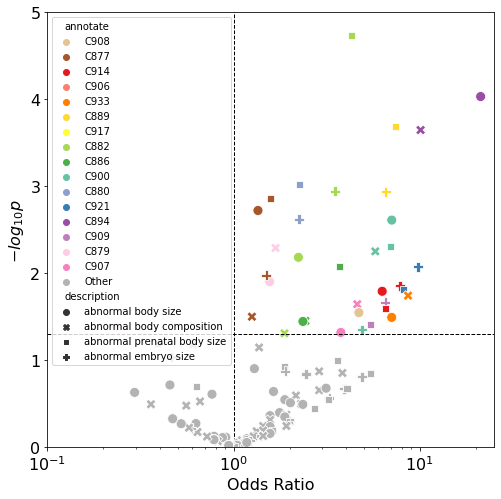

In [412]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=comm_results_body_size, x="OR", y="-log10p", style="description", hue="annotate",
               hue_order=["C908","C877","C914","C906","C933","C889","C917","C882", "C886", "C900","C880","C921","C894",
               "C909","C879","C907", "Other"],
               legend="brief", palette=my_palette,
               s=100, ax=ax)
plt.xscale("log")
plt.xlabel("Odds Ratio", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\minus log_{10}p$", fontsize=16)
plt.vlines(1, 0, 5, "black", "dashed", zorder=0, linewidths=1)
plt.hlines(-1 * np.log10(0.05), 0.1, 25, "black", "dashed", linewidths=1)
ax.margins(0)
plt.ylim(0, 5)
plt.savefig(FIGDIR+"volcano_with_legend.png", bbox_inches="tight", dpi=400)

## Significant communities in annotated BMI systems map

We visualize the enrichments for body size traits across the system by showing the log2(OR) for any system-trait pair with a lenient p-value < 0.05. We use this cutoff just to prioritize systems for more detailed investigation, including enrichment for more specific body size phenotypes.

In [452]:
# extract just the systems that were functionally annotated above
system_map_results = comm_results_body_size[comm_results_body_size["name"].isin(annotated_systems.index)]

In [455]:
# order the systems to match the hierarchy layout
node_list = ["C894", "C891", "C884", "C879", "C907", "C909", "C878", "C883", "C912", "C885",
            "C887", "C917", "C889", "C931", "C882", "C886", "C900", "C904", "C888", "C929",
            "C880", "C934", "C920", "C881", "C905", "C899", "C918"]

In [458]:
def plot_community_heatmap(results, traits, node_list,MPO, annotations, filter_th=0.05, stat="OR", filter_stat="OR_p",
                          ylabel_groups=None, color_range=None, vert=None, horz=12, xlabel="name"):
    
    keep_cols = list(set(["name", "description", stat, filter_stat, xlabel]))
    body_size_results = results.loc[traits, keep_cols]
    body_size_results["MP"] = body_size_results.index
    body_size_results = body_size_results.reset_index(drop=True)
   
    body_size_results["description"] = body_size_results["description"].apply(lambda x: x.split("abnormal ")[-1])
    #body_size_results = body_size_results.merge(annotations, left_on="name", right_on="represents")
    keep_nodes = [node for node in node_list if node in body_size_results["name"].values]
    missing_nodes = [n for n in node_list if n not in keep_nodes]
    body_size_results = body_size_results.assign(sig_OR=[body_size_results.loc[x, stat] if 
                                                         body_size_results.loc[x, filter_stat] < filter_th else None 
                                                         for x in body_size_results.index])
    OR_table = body_size_results.loc[body_size_results["name"].isin(keep_nodes)].pivot(index="description", columns="name", values="sig_OR")
    # add null results for communities with no results
    for n in missing_nodes:
        OR_table[n] = [np.nan] * len(traits)
    # reorder the table
    OR_table = OR_table.loc[:, node_list]
    descriptions = [get_MP_description(term, MPO).split("abnormal ")[-1] for term in traits]
    OR_table = OR_table.loc[descriptions]
    # ignore "negative" enrichments
    OR_table[OR_table < 1] = np.nan
    
    # plot results
    if vert is None:
        _, ax = plt.subplots(figsize=(horz,2*(len(traits))/6))
    else:
        _, ax = plt.subplots(figsize=(horz, vert))
    if stat == "OR":
        if color_range is not None:
            sns.heatmap(np.log2(OR_table), cmap='Blues',
                        cbar_kws={"aspect":10, "ticks":[i for i in range(color_range[0], color_range[1]+1)],
                                 "orientation": 'vertical', "shrink":0.6}, 
                       vmin=color_range[0], vmax = color_range[1])
        else:
            sns.heatmap(np.log2(OR_table), cmap='Blues', cbar_kws={"aspect":10, "ticks":[0, 1, 2,3,4]})
    else:
        sns.heatmap(np.log2(OR_table), cmap='Blues', cbar_kws={"aspect":10})
    plt.ylabel("")
    plt.yticks(fontsize=14)
    if ylabel_groups is not None:
        if len(ylabel_groups) == len(traits):
            y_colors = {0:"#0C3952", 1:"#696264"}
            for ytick, color in zip(ax.get_yticklabels(), ylabel_groups):
                ytick.set_color(y_colors[color])
                ytick.set_fontsize(14)
                ytick.set_fontname('Nimbus Sans Narrow')
        else:
            print('Number of ylabel groups does not match number of labels')
            print("Labels:", len(traits))
            print("Label groups:", len(ylabel_groups))
    plt.xlabel("")
    ax.xaxis.tick_bottom()
    if xlabel != "name":
        labels = [annotations.loc[x].annotation for x in node_list]
        _ = plt.xticks(ticks=ax.get_xticks(), labels=labels, rotation=90, fontsize=14)
    else: 
        _ = plt.xticks(rotation=90, fontsize=14)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Log2("+stat+") for communities where "+filter_stat+" < "+str(filter_th), fontsize=14)
    return OR_table

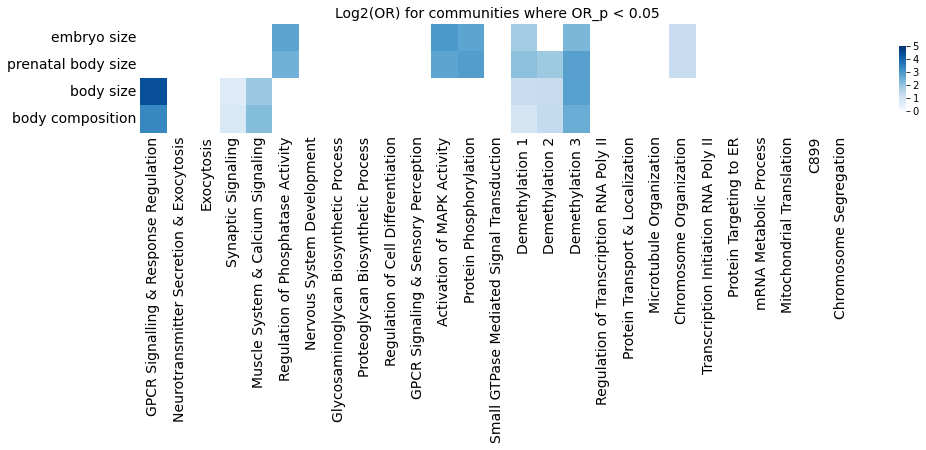

In [461]:
_ = plot_community_heatmap(system_map_results, body_size_traits, node_list, annotations=final_annotations, stat="OR", filter_stat="OR_p", 
                       color_range = [0, 5], MPO=MPO, vert = 2, horz=16, xlabel="annotation", filter_th=0.05)

Secondly,  we identify all communities in the full 61-community system map showing a significant enrichment for at least one body size trait with q < 0.1. This table displays the corresponding odds ratio.  We see a number of un-annotated communities that show a significant enrichment for one or more body size phenotype:
* C933
* C914
* C908
* C906
* C921

In [462]:
comm_results_body_size[comm_results_body_size.OR_p < 0.05].pivot("annotation", "description", "OR").sort_values(by=["abnormal body composition", 
                                                                                                                   "abnormal body size",
                                                                                                                  "abnormal prenatal body size"], ascending=False)

description,abnormal body composition,abnormal body size,abnormal embryo size,abnormal prenatal body size
annotation,,,,
GPCR Signalling & Response Regulation,10.102989,21.234418,NaN,NaN
C933,8.648328,7.065250,NaN,NaN
Demethylation 3,5.768622,7.070778,4.900602,6.980830
Muscle System & Calcium Signaling,4.613237,3.768549,NaN,NaN
Demethylation 2,2.429395,2.356947,NaN,3.705634
Demethylation 1,1.876110,2.228843,3.500674,4.289175
Synaptic Signaling,1.680140,1.563655,0.232674,NaN
Conserved BMI Network (root),1.254052,1.351790,1.499567,1.582840
C914,NaN,6.281724,7.842278,6.510193


## Endophenotypes of BMI-relevant communities

The MGD mutant collection also allows us to identify "endophenotypes" underlying the relationships between protein communities and body size phenotypes. Here we summarize the high level enrichments across the body size enriched communities within the heirarchy. Terms are selected to cover the key phenotypes impacted by the significantly enriched communities.

In [474]:
size = [1697, 10866 ] + [ 3956, 5451] # body size phenotypes
skel = [8395] # skeleton phenotypes
cell = [5076, 313] # cellular phenotypes
neo = [2019] # neoplasm phenotypes
ag = [8762, 10770] # Aging phenotypes
cardio = [2925, 10630, 4215] # Cardiovascular phenotypes
muscle = [759, 4087, 2269] # Muscle phenotypes
homeostasis = [5164, 3953, 2078] # Homeostasis and Metabolism phenotypes
exo = [2164, 2163] # Exocrine gland phenotypes
behavior = [14114,2069, 2066,  2067] # Behaviour phenotypes
nervous = [4811, 8946,2152,3861] # Nervous system phenotypes
all_terms = size+skel +cell +neo+ag +cardio + muscle + homeostasis + exo + behavior+nervous
all_terms = [num_to_mp(term) for term in all_terms]

all_groups = []
for i, term_list in enumerate([size, skel, cell,neo,ag, cardio, muscle, homeostasis, exo, behavior, nervous]):
    all_groups += [i%2]*len(term_list)


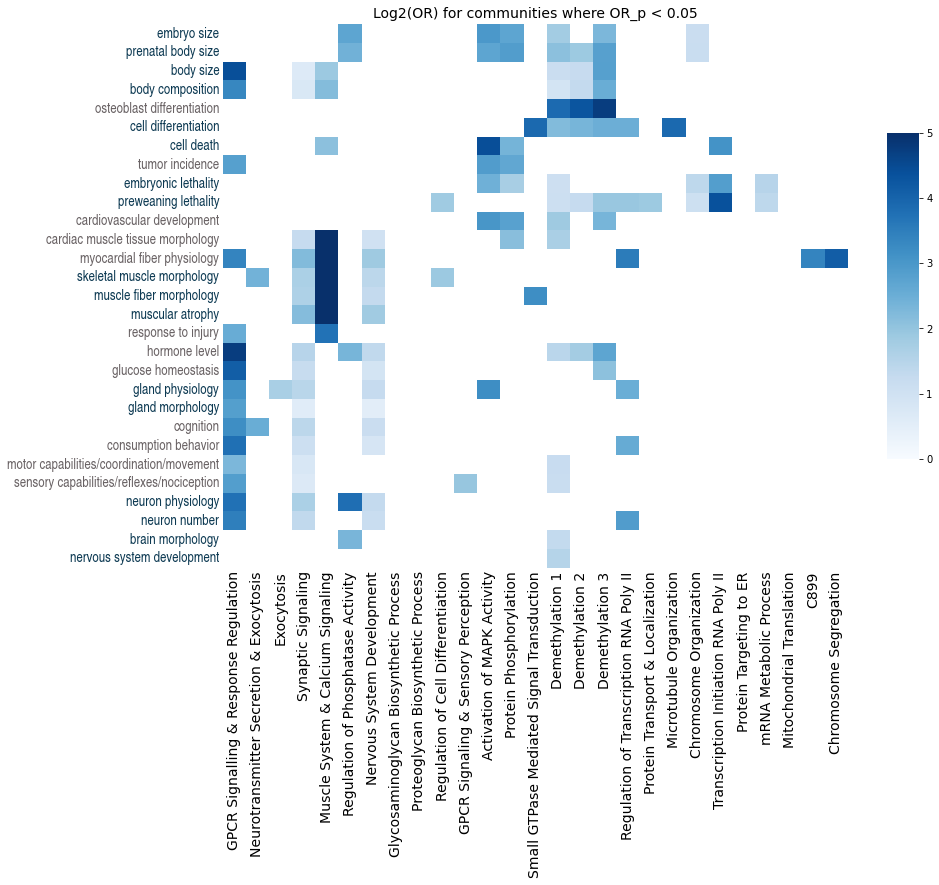

In [475]:
_ = plot_community_heatmap(bmi_pheno_results, all_terms, node_list, annotations=final_annotations, 
                           stat="OR", filter_stat="OR_p", color_range = [0, 5], MPO=MPO, 
                           vert = 10, horz=14, xlabel="annotation", filter_th=0.05,
                          ylabel_groups=all_groups)

### Example 1: GPCR Signaling & Response Regulation (GSR)

PARENT: MP:0000001 mammalian phenotype


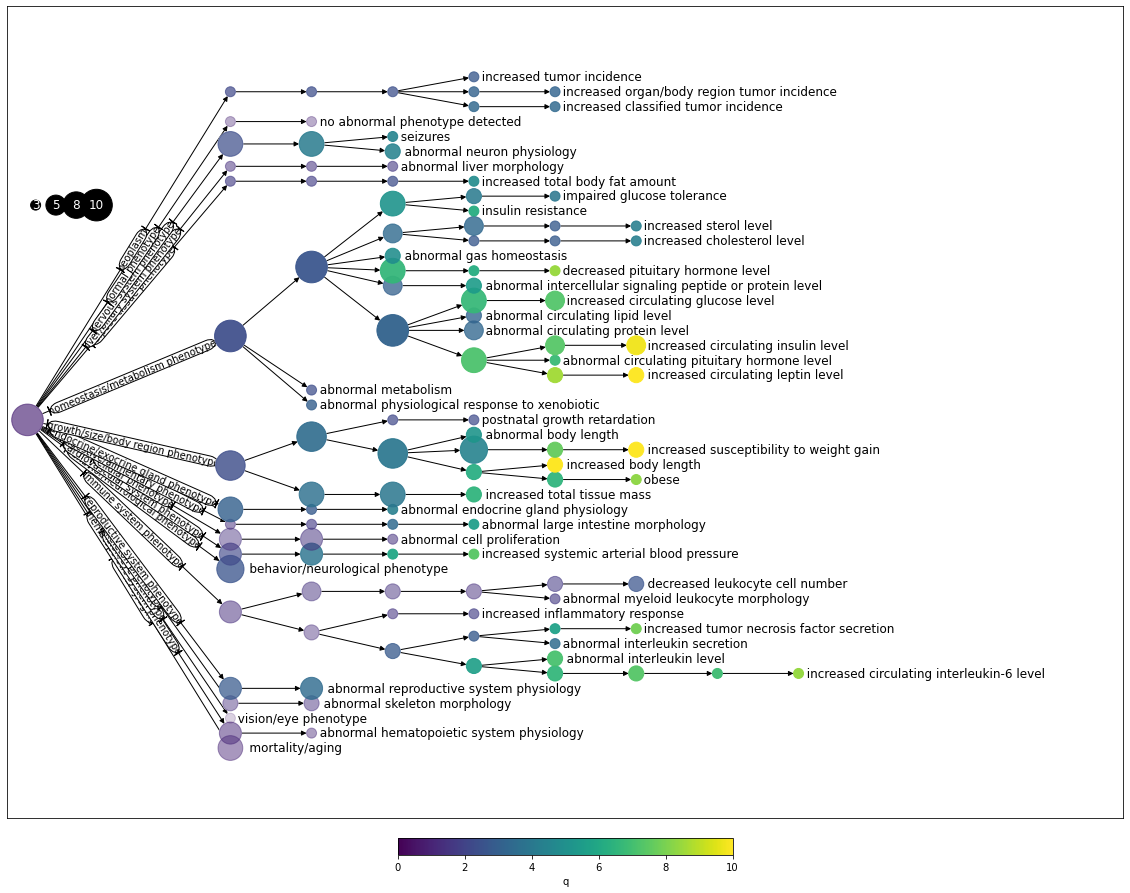

In [607]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=3], "C894", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=18, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Example 2: Muscle System & Calcium Signaling (MSC)

PARENT: MP:0000001 mammalian phenotype


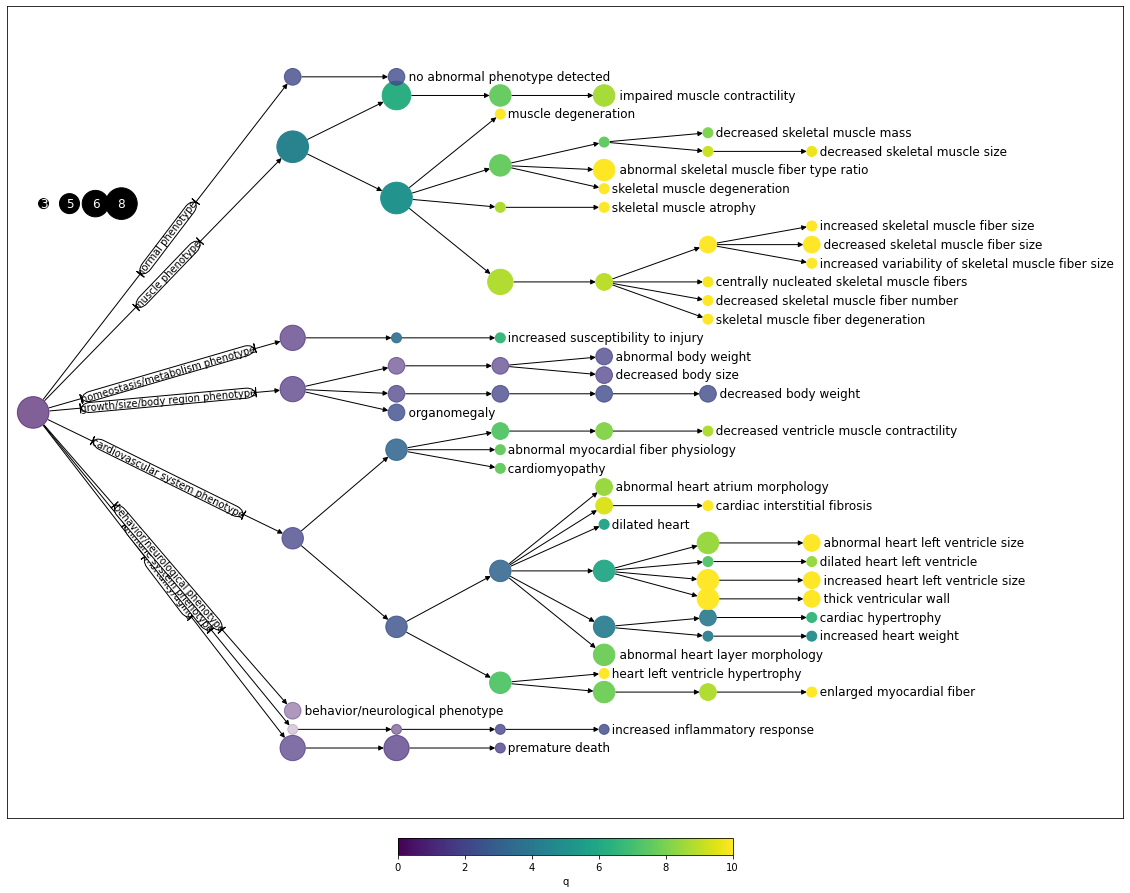

In [609]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=3], "C907", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=18, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Example 2: Demethylation (DM1)

PARENT: MP:0000001 mammalian phenotype


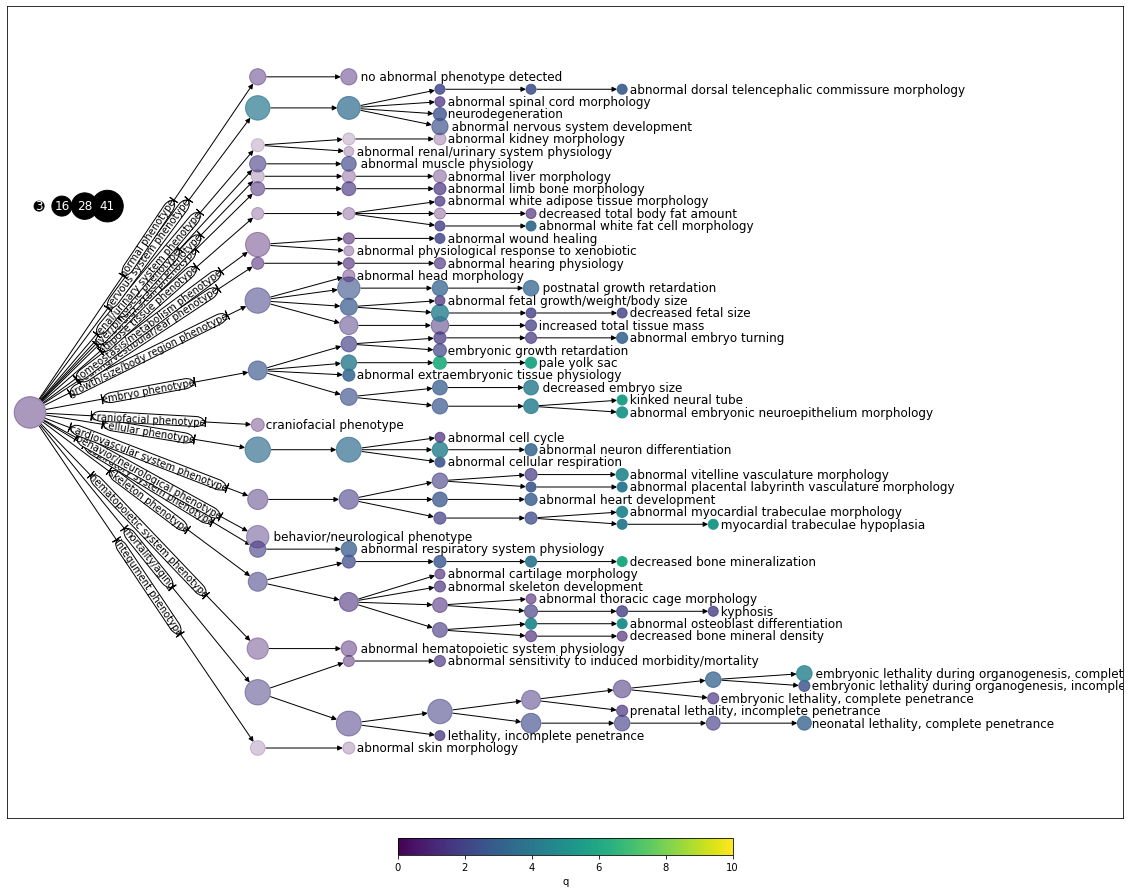

In [612]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=3], "C882", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=18, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Example 4: Regulation of Phosphatase Activity (RPA)

PARENT: MP:0000001 mammalian phenotype


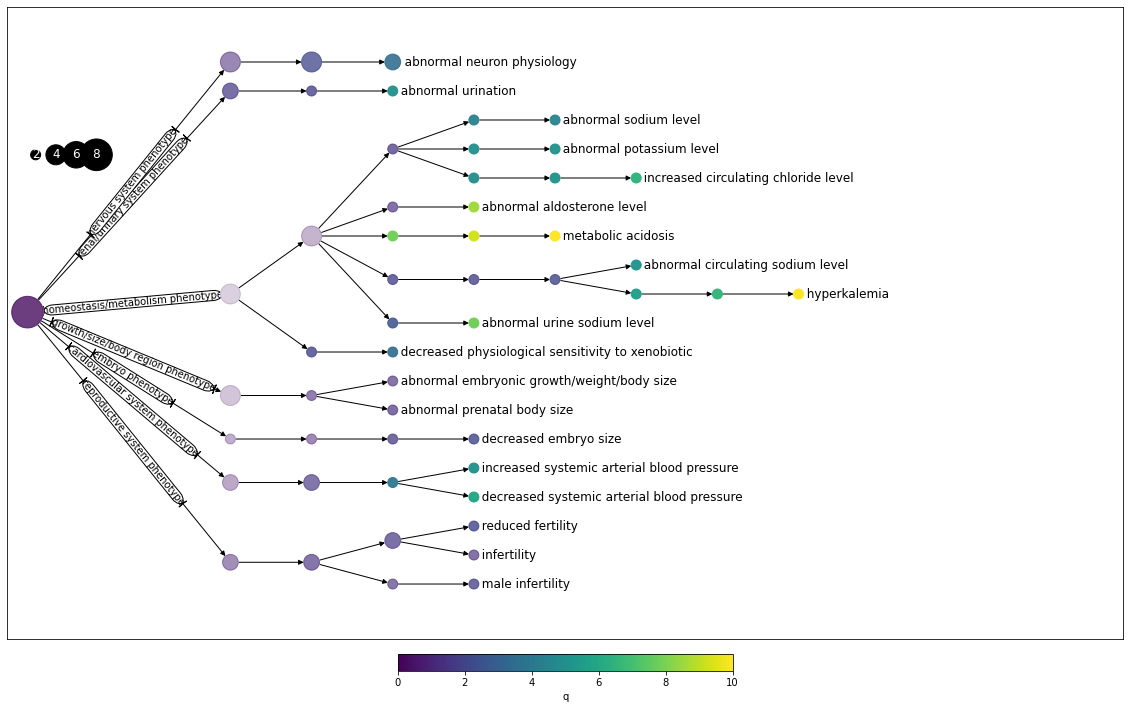

In [617]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C909", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=14, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### Example 5: Activation of MAPK

PARENT: MP:0000001 mammalian phenotype


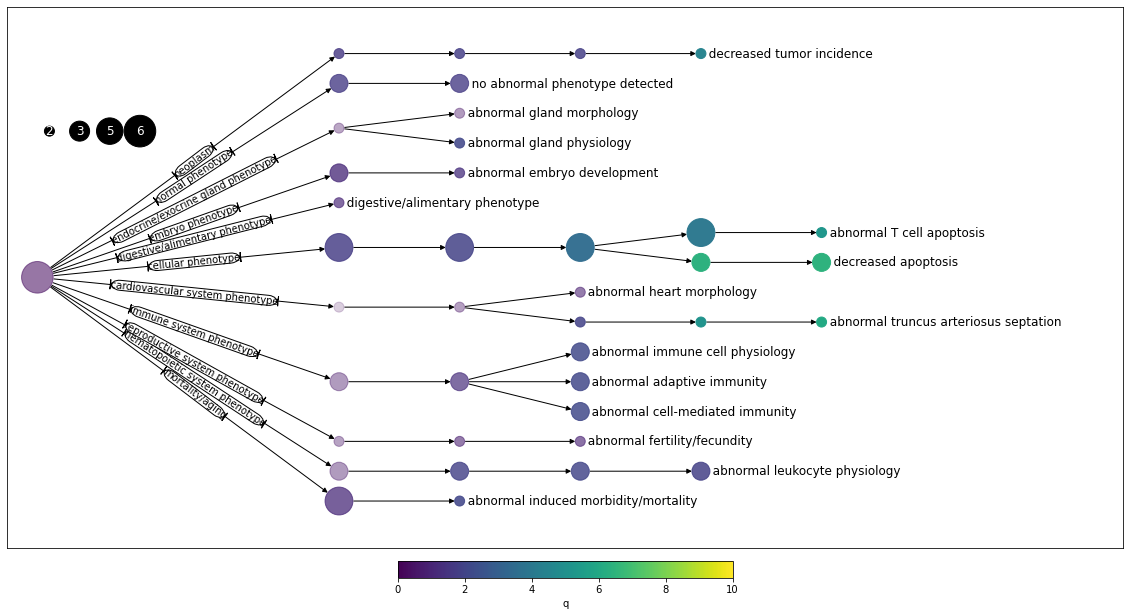

In [616]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C917", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=12, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

## Phenotypes associated with unannotated communties

We find 5 communities that are enriched for genes related to body size phenotypes that were unannotated for common function via GO. 

To identify potential functional roles of these communities we assess enrichments for gene associated with phenotypes across the mammalian phenotype ontology. For each community we assess enrichment for the 28 highest level phenotype categories and examine subsequent levels of the ontology by keeping only child terms with a higher Positive Predictive Value (PPV) than the parent. 

In [477]:
other_comms = ["C933", "C914", "C908", "C906", "C921"]

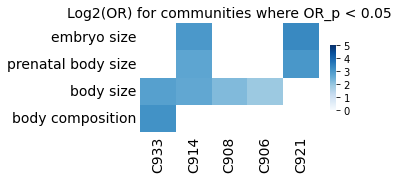

In [482]:
_ = plot_community_heatmap(bmi_pheno_results, body_size_traits, other_comms, annotations=final_annotations, 
                           stat="OR", filter_stat="OR_p", color_range = [0, 5], MPO=MPO, 
                           vert = 2, horz=4, xlabel="annotation", filter_th=0.05,
                          )

In [494]:
top_level_phenotypes = get_top_level_terms(mp_graph)

In [555]:
def plot_hbar_phenotypes(data_all, community, mps, name, sort_by=None, sig_level=0.05, mp_graph=None, vert=10, horz=6,
                        correct_p_values=True):
    if type(mps) == str and mp_graph is not None:
        mps = [node for node in nx.dfs_preorder_nodes(mp_graph, mps, 1) if node in data_all.index][1:]
        
    community_plot_data = []
    data = data_all.loc[mps]
    data = data.loc[data["name"] == community]
    data["q"] = fdrcorrection(data["OR_p"], method="poscorr")[1]
    data["q_hyper"] = fdrcorrection(data["hyper_p"], method="poscorr")[1]
    cmap = {community:(14/255,142/255,18/255)}
    
    sort_data = data.sort_values(by=["q", "OR_p"], ascending=False)
    extra_mps = [mp for mp in mps if mp not in sort_data.index ]
    mps = extra_mps + list(sort_data.index.values)
    
    
    plot_data = pd.DataFrame({"mps":mps, "community":comm, "left":1.0, "width":0.0, "upper":0, "lower":0, 
                                  "fill":[(1,1,1)], "hatch":""}, index=mps)  
    
    comm_nodes = [node for node in mps if (node in data.loc[data.name==community].index)]
    results = data.loc[data.name==community]
    results = results.assign(sig=[cmap[community] if val<sig_level else (1,1,1) for val in results["q"]])
    sig_bars = results.loc[results["q"] < sig_level].index
    results = results.assign(hypsig=["/" if val < sig_level else "" for val in results.q_hyper])
    

    
    
    try:
        plot_data = plot_data.assign(left=[min(1, results.loc[mp, "OR"]) if mp in results.index else 1.0 for mp in plot_data.index], 
                                         width=[max(1-results.loc[mp, "OR"], results.loc[mp, "OR"]-1) if mp in results.index else 0.0 for mp in plot_data.index], 
                                         upper=[results.loc[mp, "OR_CI_upper"] - results.loc[mp, "OR"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        lower =[results.loc[mp, "OR"] - results.loc[mp, "OR_CI_lower"] if mp in results.index else 0.0 for mp in plot_data.index],
                                        fill =[results.loc[mp, "sig"] if mp in results.index else (1,1,1) for mp in plot_data.index], 
                                        hatch = [results.loc[mp, "hypsig"] if mp in results.index else ""for mp in plot_data.index])
    except:
        return plot_data, results, comm
    neg_bars = plot_data.loc[plot_data["left"] < 1].index
    plot_data = plot_data.assign(upper=[results.loc[x, "OR_CI_upper"] - 1 if x in neg_bars else plot_data.loc[x, "upper"] for x in plot_data.index])
    plot_data = plot_data.assign(lower=[1- results.loc[x, "OR_CI_lower"] if x in neg_bars else plot_data.loc[x, "lower"] for x in plot_data.index])
        #return plot_data, cmap, comm, sig_bars
    plot_data = plot_data.assign(edgecolor=[cmap[community] if mp in results.index else (1,1,1) for mp in plot_data.index ])
    plot_data = plot_data.assign(ecolor=[(darken(cmap[community])) if mp in sig_bars else (alpha_blending(cmap[community], 0.3)) for mp in plot_data.index])
    plot_data = plot_data.assign(y=[i for i in range(len(plot_data))])
    
    plt.figure(figsize=(horz, vert), frameon=False)
    ax = plt.subplot(111)
    ax.barh(data=plot_data, y="y", height=0.8, left="left", color="fill", width="width", 
             xerr=(plot_data.lower, plot_data.upper), 
             edgecolor="edgecolor", ecolor="ecolor", alpha=0.7)
    
    handles = [Patch(facecolor=cmap[community])]
    handle_map = {name +  " (N=" + str(int(data.loc[data["name"]==community, "size"].values[0])) + ")": cmap[community]}
    ylabels = [data_all.loc[node, "description"].values[0] for node in mps]
    ylabels = [desc.split("abnormal ")[1] if "abnormal" in desc else desc for desc in ylabels] 
    ylabels = [desc.replace("physiology", "phys.") for desc in ylabels]
    ylabels = [desc.replace("morphology", "morph.") for desc in ylabels]
    ylabels = [desc.replace(" phenotype", "") for desc in ylabels]
    a=ax.set_yticks(ticks=[i for i in range(len(mps))] )
    ax.set_yticklabels(labels=ylabels)
    ax.set_xlabel("Odds ratio with 95% confidence interval")
    
    if max(plot_data.width) > 9:
        plt.xscale("log")
    plt.legend(handles, handle_map, loc="upper left")

In [599]:
def normalize_to_range(data, upper, lower):
    if max(data) - min(data) == 0:
        norm_data = (data / data) * (upper+lower)/2
    else:
        # normalize to unit
        norm_data = (data - min(data))/(max(data)-min(data))
        # normalize to range
        norm_data = norm_data * (upper - lower) + lower
    return norm_data


def create_legend_size_graph(node_sizes, node_data, min_size=100, max_size=1000, size_by='obs', adjust_root=0):
    G = nx.Graph()
    lower = min([sz for sz in node_sizes])
    true_lower = min(node_data[size_by])
    upper = max([sz for sz in node_sizes])
    true_upper = max(node_data[size_by])
    true_q1, true_q3 = [round(x) for x in np.quantile([true_lower, true_upper], [0.3333, 0.66667])]
    q1, q3 = np.quantile([lower, upper], [0.3333, 0.66667])
    positions = {}
    nodes_to_plot = list(set([round(true_lower), round(true_q1), round(true_q3),  round(true_upper)]))
    nodes_to_plot.sort()
    for i, node in enumerate(nodes_to_plot):
        G.add_node(node)
        positions[node] = (0.01 + 0.05*(i-1) - adjust_root*0.8, 0.4)
    if len(positions) == 1:
        leg_sizes = (min_size+max_size)/2
    elif len(positions) == 2:
        leg_sizes = [lower, upper]
    elif len(positions) == 3:
        leg_sizes = [lower, np.mean([q1, q3]), upper]
    else:
        leg_sizes = [lower, q1, q3, upper]
        
    return G, leg_sizes, positions


def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/(xmax+1), pos[node][1])
    return pos


def draw_significance_hierarchy(data, community, root, mpG, MPO, hier_df_genes, term_mapping, select_on="q", size_by="OR", 
                                color_by="q", alpha_by=None, 
                                vert=10, label="all", descriptive_labels=False,
                               adjust_root=0):
    if "MP" not in data.columns:
        data = data.assign(MP=data.index)
    
    try:
        comm_genes = hier_df_genes.loc[community, "CD_MemberList"].split(" ")
    except AttributeError:
        comm_genes = hier_df_genes.loc[community, "CD_MemberList"]
    data = data.loc[data.name==community]
    stop = False
    sigH = []
    queue = []
    if select_on=="hypergeom":
        all_hypers = {root:1.0}
    current=root
    previous=root
    data = data.assign(ppv=data.observed/data.total)
    while not stop:
        children = [node for node in nx.dfs_preorder_nodes(mpG, current, 1)]
        if len(children) == 0:
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True
        else:
            node_order = [node for node in children if node in data.index]
            subset = data.loc[node_order]
            subset.loc[:, "q"] = fdrcorrection(subset.OR_p, method="poscorr")[1]
            if select_on=="q":
                new_sigs = list(subset.loc[subset.q < subset.loc[current, "q"], "MP"].values)
            elif select_on=="OR":
                new_sigs = list(subset.loc[subset.OR > subset.loc[current, "OR"], "MP"].values)
            elif select_on=="ppv":
                new_sigs = list(subset.loc[subset.ppv > subset.loc[current, "ppv"], "MP"].values)
            elif select_on=="hypergeom":
                term_counts = {term: len(term_mapping[term]) for term in term_mapping}
                parent_size = term_counts[current]
                parent_observed = data.loc[current, "observed"]
                parent_hyper = all_hypers[current]
                new_sigs = []
                for child in node_order:
                    child_hyper = hypergeom.sf(M=parent_size, n=parent_observed, N=term_counts[child], 
                                            k=subset.loc[child, "observed"]-1)
                    if child_hyper < parent_hyper:
                        new_sigs.append(child)
                        all_hypers[child] = child_hyper
            elif select_on=="qxOR":
                subset = subset.assign(qxOR=-1 * np.log10(subset.q) * subset.OR)
                new_sigs = list(subset.loc[subset.qxOR > subset.loc[current, "qxOR"], "MP"].values)
        
            queue += [(current, sig) for sig in new_sigs if sig != current]
            sigH.append((current, previous, subset.loc[current, "q"], subset.loc[current, "OR"], subset.loc[current, "observed"]))
            if len(queue) > 0:
                previous, current = queue.pop()
            else:
                stop=True  
    sigG = nx.DiGraph()
    sigG.add_node(sigH[0][0], OR=sigH[0][3], q=-1*np.log10(sigH[0][2]), obs=sigH[0][4])
    for edge in sigH[1:]:
        sigG.add_node(edge[0], OR=edge[3], q=-1*np.log10(edge[2]), obs=edge[4])
        if sigG.in_degree[edge[0]] < 1:
            sigG.add_edge(edge[1], edge[0])
    node_data = pd.DataFrame.from_dict(sigG.nodes, orient='index')
    # add the gene hits for each node
    hit_sets = [list(get_gene_hits_no_annotation(comm_genes, term, MPO, term_mapping)) for term in node_data.index.values]
    node_data = node_data.assign(hits=hit_sets)
    H = nx.convert_node_labels_to_integers(sigG, label_attribute="node_label")
    plt.figure(figsize=(20,vert))
    pos = hierarchy_pos(sigG,root=root, leaf_vs_root_factor=1)
    # get term descriptions
    descriptions = MPO.node_attr
    descriptions.index.name=None
    # create sizes
    max_size=1000
    min_size=100
    node_sizes= normalize_to_range(node_data[size_by], upper=max_size, lower=min_size)
    # get transparency values
    max_alpha=1
    min_alpha=0.2
    if alpha_by in ["q", "OR", "obs"]:
        node_alphas = list(normalize_to_range(1 - 1 / node_data[alpha_by].values, upper=max_alpha, lower=min_alpha))
    else:
        node_alphas = 1
    # get labels
    hrz="left"
    vrt="center"
    if label == "all":
        node_labels = {node:node for node in node_data.index.values}
        hrz = "center"
        vrt='bottom'
    elif label == "leaf":
        if descriptive_labels:
            labels = [" "*(2+int(node_sizes[i]/200)) + descriptions.loc[node, "description"] if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        else:
            labels = [" "*(2+int(node_sizes[i]/200)) + node if (sigG.out_degree[node]==0) else "" for i, node in enumerate(node_data.index.values)]
        node_labels = {node_data.index.values[i]:labels[i] for i in range(len(labels))}
    # plot results
    pos2 = {key:(-1*pos[key][1], pos[key][0]) for key in pos.keys()}
    
    pos2[root] = (-1 * adjust_root, pos2[root][1])
    nx.draw_networkx(sigG,with_labels=True, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color="white", label="test", edgelist=None,
                    labels=node_labels, horizontalalignment=hrz, verticalalignment=vrt, font_size=12)
    
    if color_by == "q":
        c_min = 0
        c_max = 10
    elif color_by == "OR":
        c_min = -0.5
        c_max = 10
    else:
        c_min = min(node_data[color_by])
        c_max = max(node_data[color_by])
    
    n = nx.draw_networkx_nodes(sigG, pos=pos2, node_size=node_sizes, nodelist=list(node_data.index),
                    node_color=node_data[color_by], cmap="viridis", label="test", alpha = node_alphas,
                              vmin=c_min, vmax=c_max)
    # edge labels for edges out of root
    if descriptive_labels:
        edge_labels = [descriptions.loc[node, "description"] if sigG.has_edge(root, node) else "" for node in sigG.nodes]
    else:
        edge_labels = [node if sigG.has_edge(root, node) else "" for node in sigG.nodes]

    edge_labels = {(root, node_data.index.values[i]):edge_labels[i] for i in range(len(edge_labels))}
    if label != "all":
        nx.draw_networkx_edge_labels(sigG, pos=pos2, edge_labels=edge_labels, label_pos=0.48, 
                                     bbox={"boxstyle":bx.Round(pad=0, rounding_size=0.99),
                                          "facecolor":"white"})
    #sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_data[color_by]), vmax=max(node_data[color_by])))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=c_min, vmax=c_max))
    sm._A = []
    plt.colorbar(sm, orientation="horizontal", label=color_by, shrink=0.3, pad =0.02 )
    #nx.draw_networkx_labels(sigG, pos=pos2, font_size=12, verticalalignment="bottom", horizontalalignment="left")
    #plt.legend(n)
    legend_G, legend_sizes, legend_pos = create_legend_size_graph(node_sizes, node_data, size_by=size_by, adjust_root=adjust_root)
    #return legend_G, legend_sizes, legend_pos
    try:
        nx.draw_networkx(legend_G, pos =legend_pos, node_size=legend_sizes, node_color="black", nodelist=list(legend_G.nodes()),
                        verticalalignment="center", font_color="white")
    except ValueError as e:
        print(legend_sizes, legend_G.nodes())
        print("Could not plot size legend.", e)    
    
    print("PARENT:", root, descriptions.loc[root, "description"])
    plt.xlim(-1 * adjust_root-0.05, max([pos2[k][0] for k in pos2]) * 1.5)
    plt.show()
    return node_data


PARENT: MP:0000001 mammalian phenotype


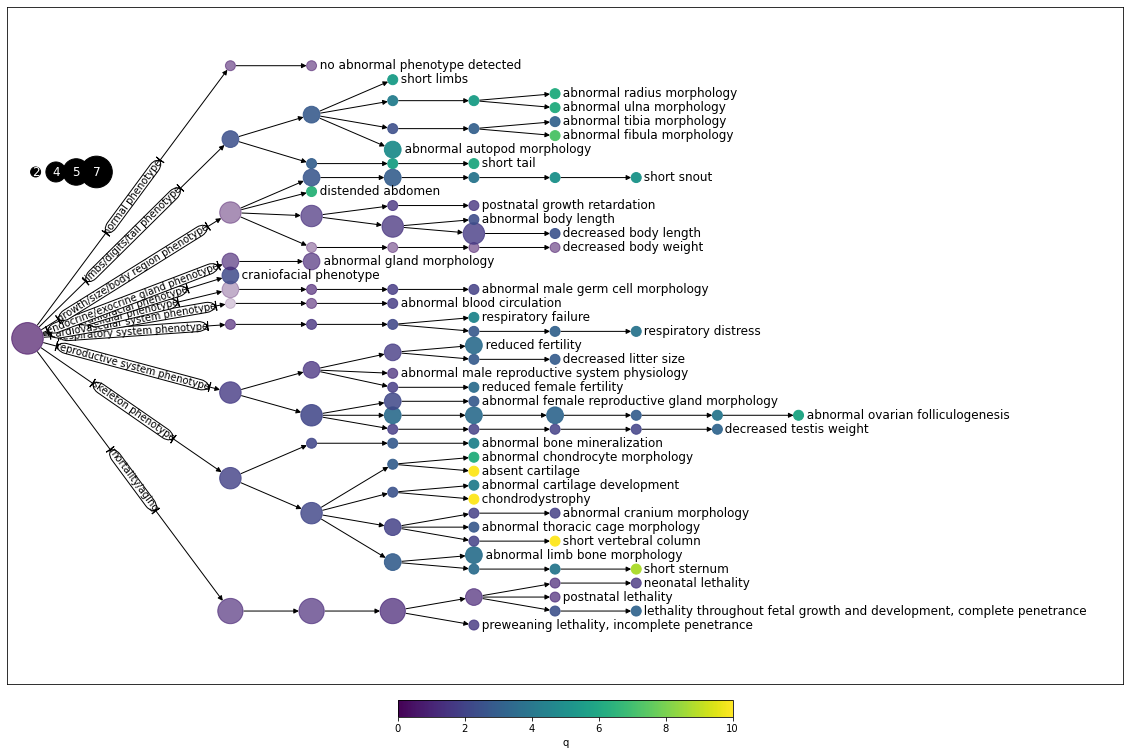

In [600]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C908", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### C933

This community is made up of 5 genes, 4 of which were identified by BMI GWAS in human and one which was identified by rat BMI GWAS

In [485]:
BMI_hier_df.loc["C933"]

CD_MemberList    [AVL9, ARFGEF2, PRKAR1A, KLC1, MSI2]
frac_d1_seeds                                     0.8
frac_d2_seeds                                     0.2
Name: C933, dtype: object

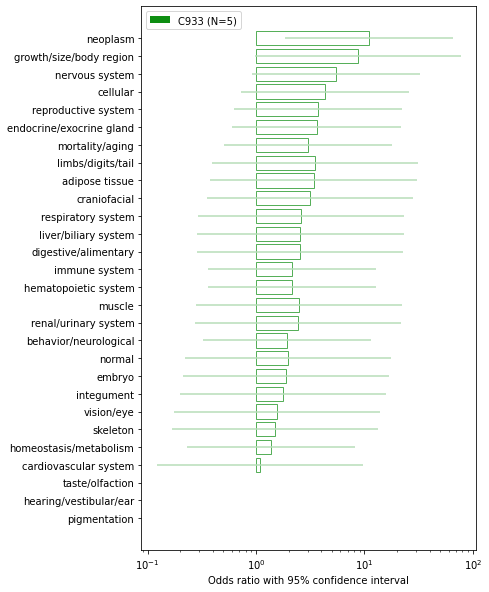

In [564]:
plot_hbar_phenotypes(bmi_pheno_results, "C933", "MP:0000001", "C933", mp_graph=mp_graph)

PARENT: MP:0000001 mammalian phenotype


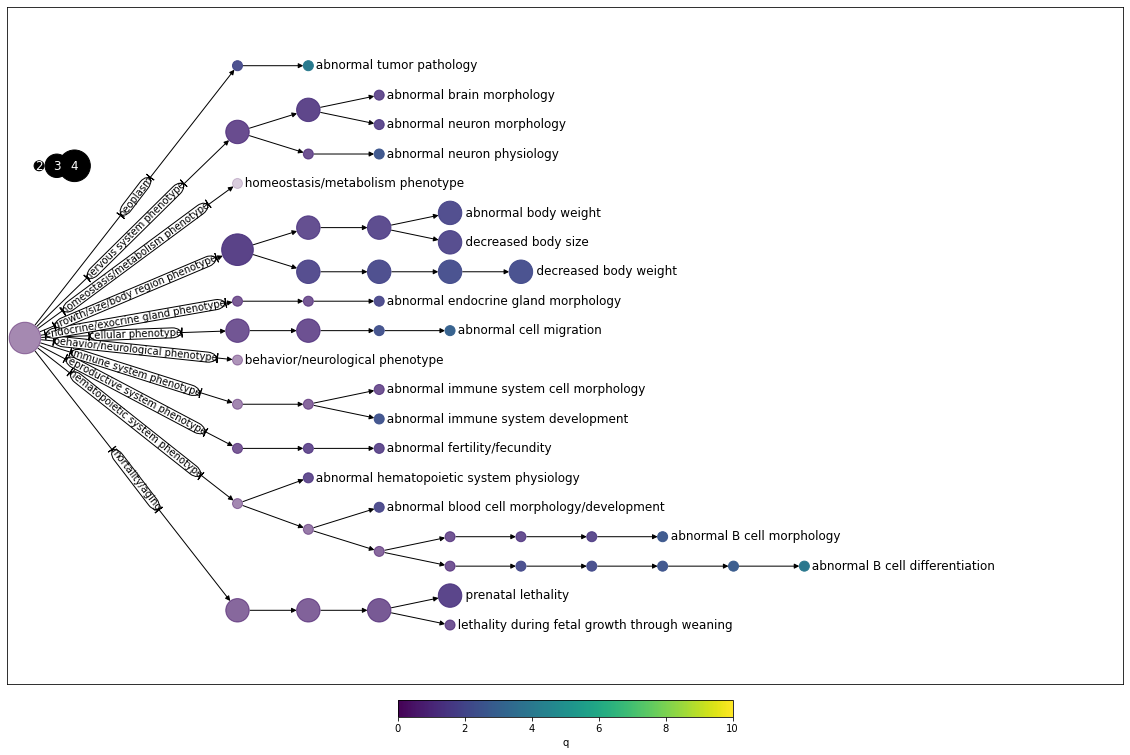

In [601]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C933", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.4)

### C914

This community is made up of 7 genes, 3 of which were identified by BMI GWAS in human and 1 which was identified by rat BMI GWAS. 

In [486]:
BMI_hier_df.loc["C914"]

CD_MemberList    [AXIN1, HHAT, MACF1, SKIL, PLEC, DVL1P1, SKIDA1]
frac_d1_seeds                                            0.428571
frac_d2_seeds                                            0.142857
Name: C914, dtype: object

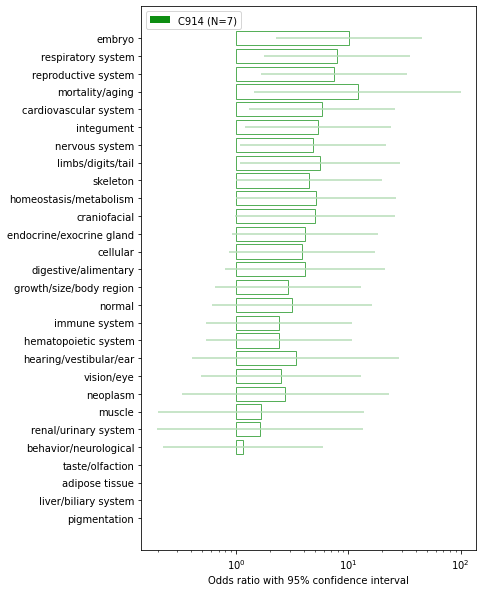

In [565]:
plot_hbar_phenotypes(bmi_pheno_results, "C914", "MP:0000001", "C914", mp_graph=mp_graph)

PARENT: MP:0000001 mammalian phenotype


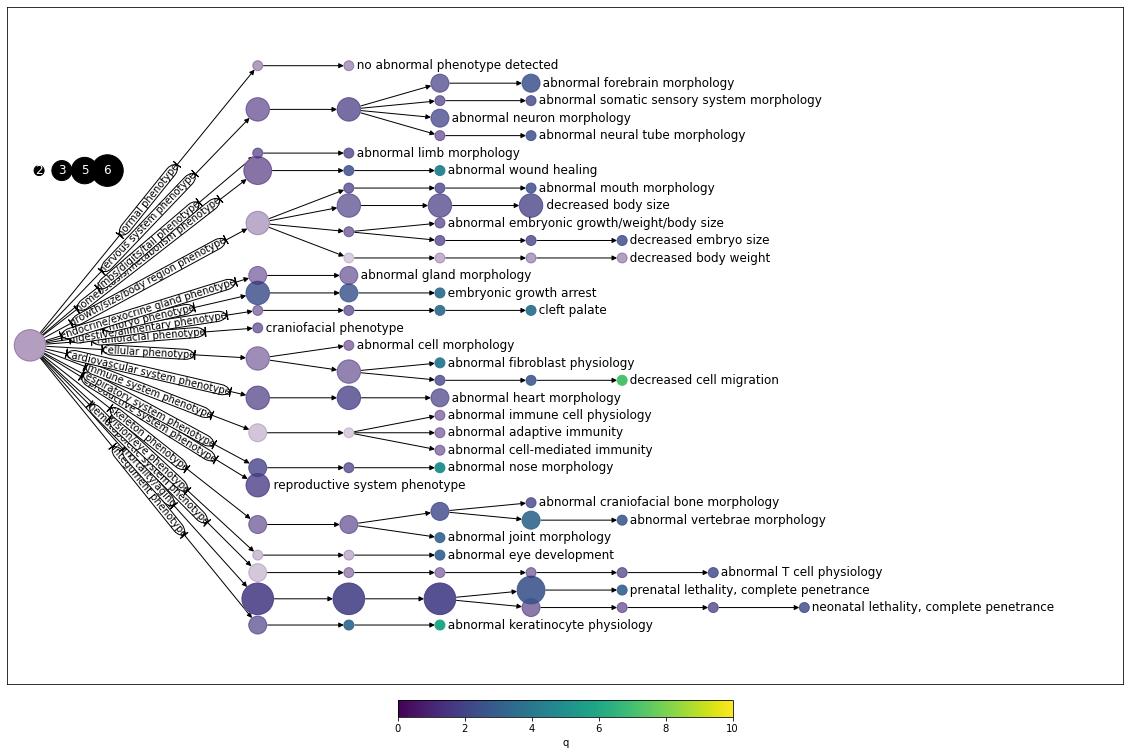

In [602]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C914", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### C908

This community is made up of 8 genes, 3 of which were identified by BMI GWAS in human and 2 which were identified by rat BMI GWAS. 

In [489]:
print(BMI_hier_df.loc["C908"])
print(BMI_hier_df.loc["C908"]["CD_MemberList"])

CD_MemberList    [TOX3, SOX6, SOX5, SOX8, AC105001.2, GAS2, PBL...
frac_d1_seeds                                                0.375
frac_d2_seeds                                                 0.25
Name: C908, dtype: object
['TOX3', 'SOX6', 'SOX5', 'SOX8', 'AC105001.2', 'GAS2', 'PBLD', 'SOX3']


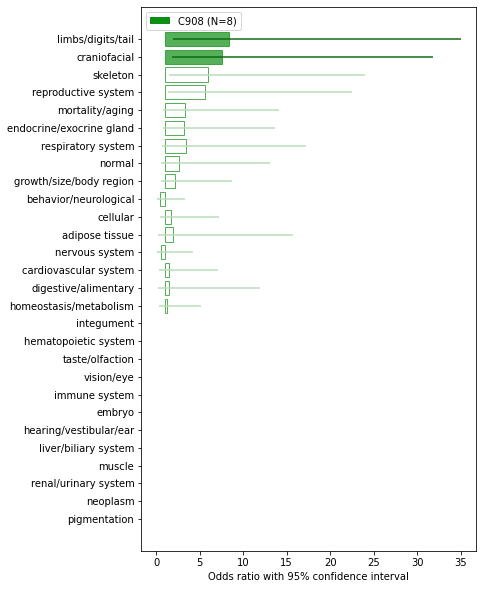

In [569]:
plot_hbar_phenotypes(bmi_pheno_results, "C908", "MP:0000001", "C908", mp_graph=mp_graph)

PARENT: MP:0000001 mammalian phenotype


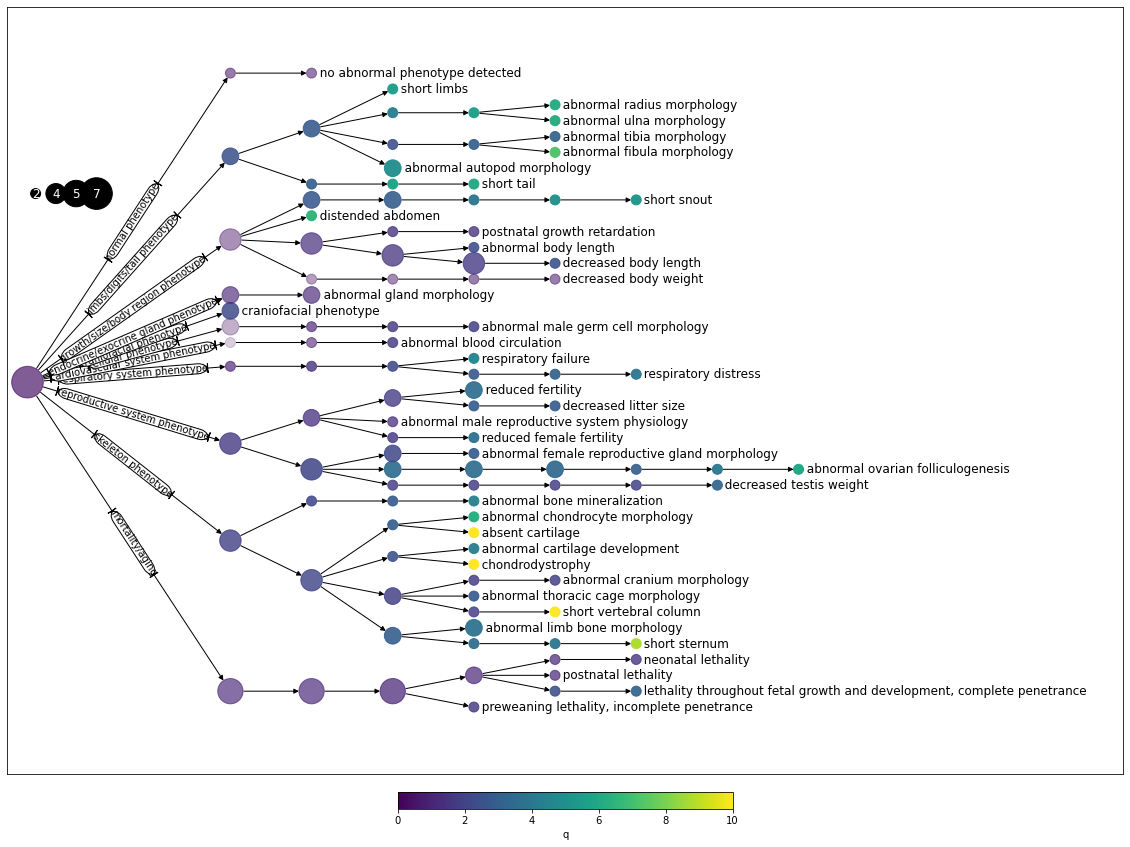

In [603]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C908", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=17, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)

### C906

This community is made up of 9 genes, 3 of which were identified by BMI GWAS in human and 1 which was identified by rat BMI GWAS. 

In [492]:
print(BMI_hier_df.loc["C906"])
print(BMI_hier_df.loc["C906"]["CD_MemberList"])

CD_MemberList    [PROM2, SPINT1, TNIK, PKP3, SSH3, FEZ2, CORIN,...
frac_d1_seeds                                             0.333333
frac_d2_seeds                                             0.111111
Name: C906, dtype: object
['PROM2', 'SPINT1', 'TNIK', 'PKP3', 'SSH3', 'FEZ2', 'CORIN', 'WWC1', 'CAPN1']


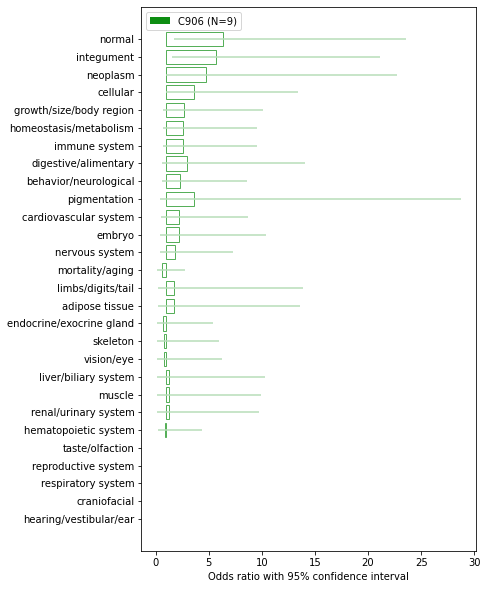

In [568]:
plot_hbar_phenotypes(bmi_pheno_results, "C906", "MP:0000001", "C906", mp_graph=mp_graph)

PARENT: MP:0000001 mammalian phenotype


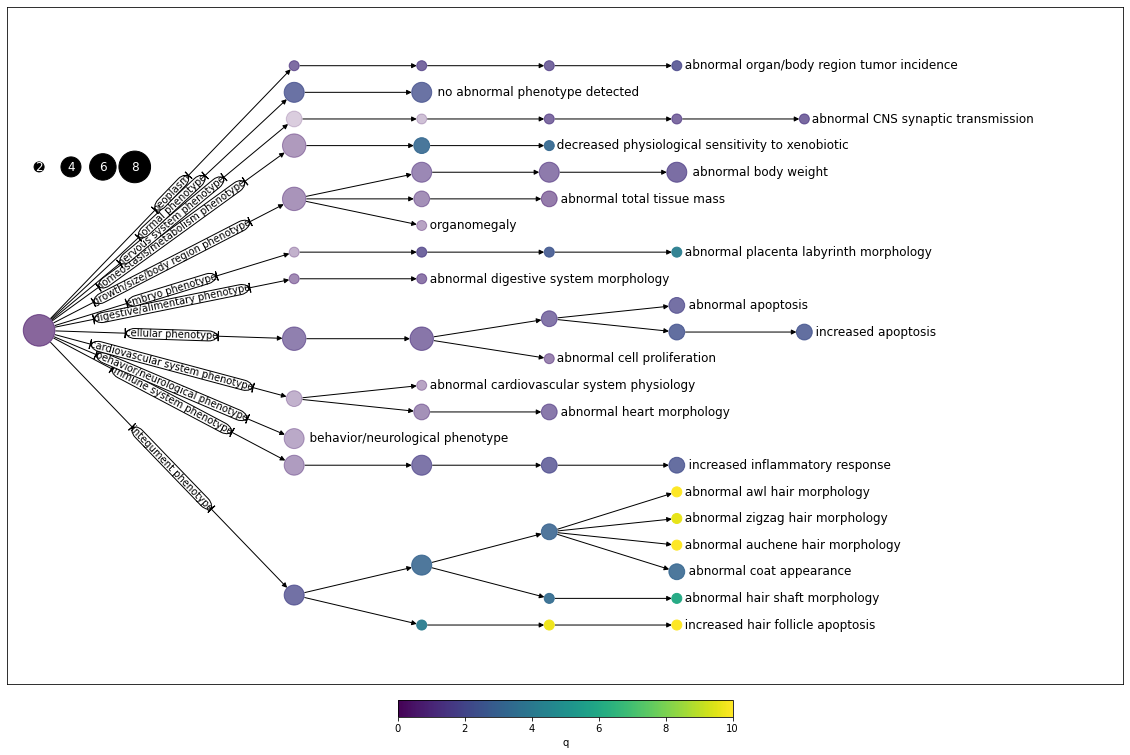

In [604]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C906", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=15, label="leaf", 
                                descriptive_labels=True, adjust_root=0.2)

### C921

This community is made up of 6 genes, 1 which was identified by BMI GWAS in human and 1 which was identified by rat BMI GWAS.

Note: only THAP11 and HCFC1 have phenotypes reported in MGI. 

In [493]:
BMI_hier_df.loc["C921"]

CD_MemberList    [THAP11, HCFC1, THAP2, THAP3, THAP7, THAP4]
frac_d1_seeds                                       0.166667
frac_d2_seeds                                       0.166667
Name: C921, dtype: object

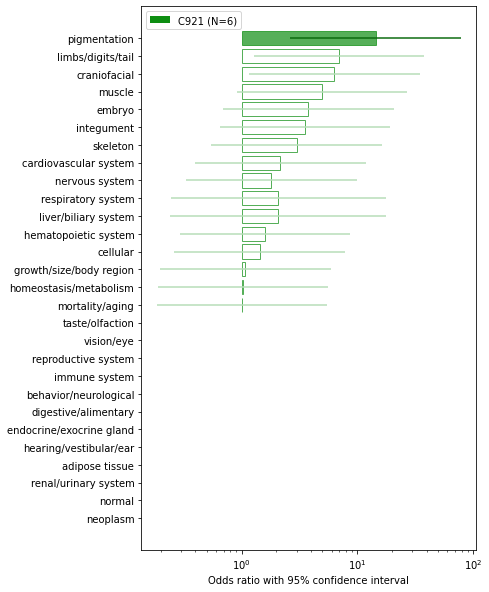

In [570]:
plot_hbar_phenotypes(bmi_pheno_results, "C921", "MP:0000001", "C921", mp_graph=mp_graph)

PARENT: MP:0000001 mammalian phenotype


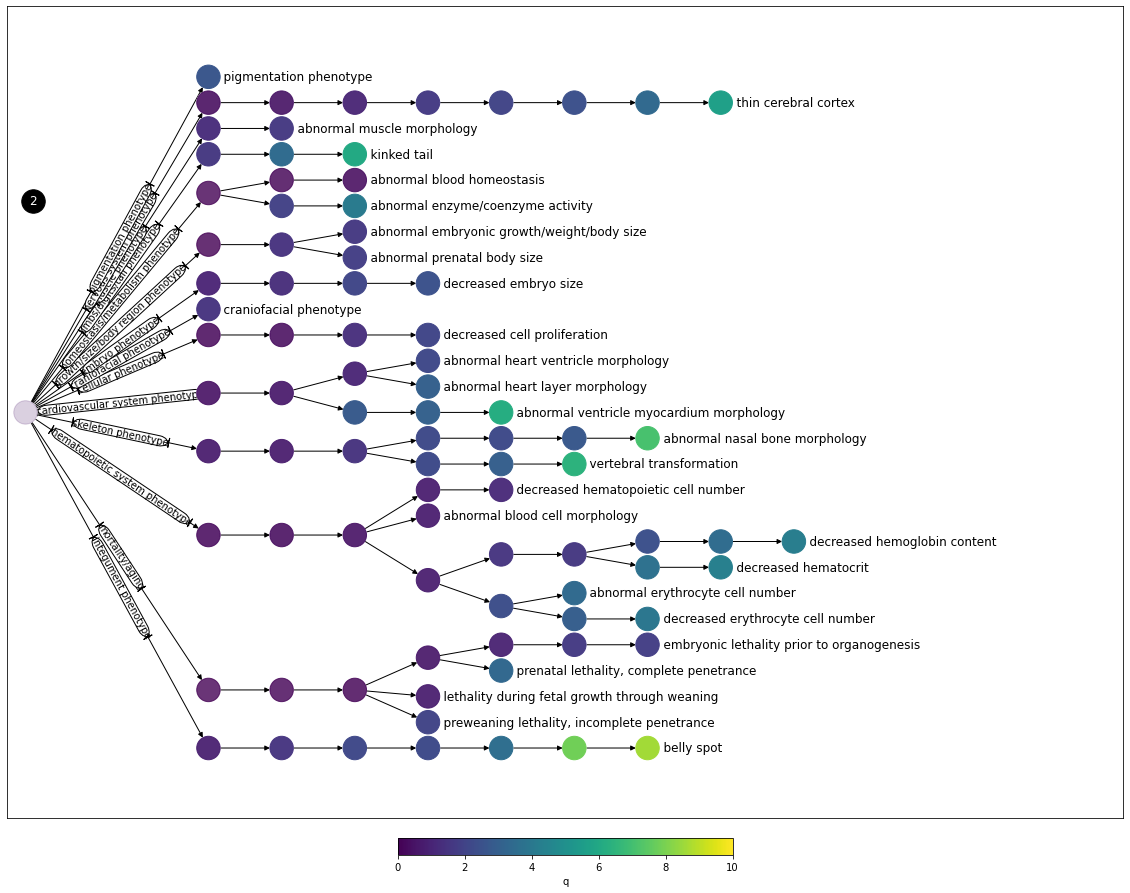

In [605]:
n = draw_significance_hierarchy(bmi_pheno_results.loc[bmi_pheno_results.observed>=2], "C921", "MP:0000001", 
                                mp_graph, MPO, BMI_hier_df, 
                                term_mapping, select_on="ppv", 
                                size_by="obs", alpha_by="OR",color_by="q", vert=18, label="leaf", 
                                descriptive_labels=True, adjust_root=0.3)